In [ ]:
# ======================================================
# Milestone 2: Baseline Learning Notebook (Regression)
# ======================================================

In [ ]:
pip install --upgrade scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 23.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ---------- 0) Config ----------
BASE_PATH = "/content/drive/MyDrive/IE434-DeepDive-EnergyPricesInIllinois/Data"  # change if needed
PROC_PATH = os.path.join(BASE_PATH, "processed")

DEBUG_PKL = os.path.join(PROC_PATH, "energy_debug.pkl")
WORK_PKL  = os.path.join(PROC_PATH, "energy_working.pkl")

In [ ]:
# ---------- 1) Load ----------
if os.path.exists(WORK_PKL):
    df = pd.read_pickle(WORK_PKL)
elif os.path.exists(DEBUG_PKL):
    df = pd.read_pickle(DEBUG_PKL)
else:
    raise FileNotFoundError("Processed pickle not found. Check your paths.")

We mount Google Drive, define file paths for our processed datasets, and load the cleaned energy price data (energy_working.pkl or fallback to energy_debug.pkl).
We also ensure the date column is parsed correctly and sort the data chronologically.

In [ ]:
# Ensure date sorting
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)

In [ ]:
# Label (same convention as EDA)
possible_label_cols = [c for c in df.columns if "actual_energy_price" in c]
if not possible_label_cols:
    # fallback heuristic
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not numeric_cols:
        raise ValueError("No numeric columns to serve as label.")
    label_col = numeric_cols[0]
    print(f" Using {label_col} as label heuristically.")
else:
    label_col = possible_label_cols[0]

 Using price_actual as label heuristically.


In [ ]:
# ---------- 2) Minimal Feature Set ----------
# Start simple to avoid leakage:
# - Day-ahead price (if present)
# - Calendar features (day_of_week, hour_of_day, month)
# - Optional: simple lag of target (yesterday's price) to give a naïve persistence signal

if "day_ahead_energy_price" in df.columns:
    feature_cols_num = ["day_ahead_energy_price"]
else:
    feature_cols_num = []  # we will still rely on calendar + optional lags

We select a simple and interpretable baseline feature set to avoid data leakage.
This includes:

Calendar features: day_of_week, hour_of_day, month

Optional numerical features: day_ahead_energy_price (if available)

Lag feature: lag1_label — the previous hour’s price, to capture short-term temporal dependencies.

We then drop rows with missing lag values to keep the dataset consistent.

In [ ]:
# Calendar features
if "day_of_week" not in df.columns:
    df["day_of_week"]  = df["date"].dt.day_name()
if "hour_of_day" not in df.columns:
    df["hour_of_day"]  = df["date"].dt.hour
if "month" not in df.columns:
    df["month"]        = df["date"].dt.month

feature_cols_cat = ["day_of_week"]
feature_cols_num += ["hour_of_day", "month"]

In [ ]:
# Optional: add a simple lag to avoid pure leakage (lag 1 hour if hourly data; adjust if granularity differs)
# Only compute lag from past rows.
df["lag1_label"] = df[label_col].shift(1)
feature_cols_num.append("lag1_label")

# Drop rows where lag is NA
df_model = df.dropna(subset=feature_cols_num + [label_col]).copy()

In [ ]:
# ---------- 3) Time-Based Split ----------
# Use last 20% as test (recent period). You can also use a date threshold.
split_idx = int(0.8 * len(df_model))
train = df_model.iloc[:split_idx].copy()
test  = df_model.iloc[split_idx:].copy()

X_train = train[feature_cols_num + feature_cols_cat]
y_train = train[label_col].values
X_test  = test[feature_cols_num + feature_cols_cat]
y_test  = test[label_col].values

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (1622693, 4) Test size: (405674, 4)


We split the dataset chronologically, using the first 80% for training and the most recent 20% for testing, ensuring that our model simulates real-world forecasting without using future information.

In [ ]:
# ---------- 4) Preprocess & Model ----------
num_transformer = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=True, with_std=True))
])
cat_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_transformer, feature_cols_num),
        ("cat", cat_transformer, feature_cols_cat),
    ],
    remainder="drop"
)

We build data preprocessing pipelines using:

StandardScaler for numerical features

OneHotEncoder for categorical features

We then combine them using a ColumnTransformer and define two baseline regression models:

Ordinary Least Squares (LinearRegression)

Ridge Regression (regularized linear model)

In [ ]:
# Baseline: Ordinary Least Squares
ols = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LinearRegression())
])

# Optional: Ridge as a slightly more stable baseline
ridge = Pipeline(steps=[
    ("prep", preprocess),
    ("model", Ridge(alpha=1.0, random_state=42))
])

We fit both the OLS and Ridge regression pipelines on the training data.
This step learns the linear relationships between energy prices and the chosen predictors.

In [ ]:
# ---------- 5) Train ----------
ols.fit(X_train, y_train)
ridge.fit(X_train, y_train)

,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
# ----------- 6) Evaluate -----------
def evaluate(name, pipe, X_tr, y_tr, X_te, y_te):
    pred_tr = pipe.predict(X_tr)
    pred_te = pipe.predict(X_te)

    mae_tr = mean_absolute_error(y_tr, pred_tr)
    mae_te = mean_absolute_error(y_te, pred_te)

    mse_tr = mean_squared_error(y_tr, pred_tr)
    mse_te = mean_squared_error(y_te, pred_te)
    rmse_tr = mse_tr ** 0.5
    rmse_te = mse_te ** 0.5

    ss_res_tr = ((y_tr - pred_tr) ** 2).sum()
    ss_tot_tr = ((y_tr - y_tr.mean()) ** 2).sum()
    r2_tr = 1 - ss_res_tr / ss_tot_tr

    ss_res_te = ((y_te - pred_te) ** 2).sum()
    ss_tot_te = ((y_te - y_te.mean()) ** 2).sum()
    r2_te = 1 - ss_res_te / ss_tot_te

    print(f"\n{name} metrics")
    print(f" Train: MAE={mae_tr:.3f}   RMSE={rmse_tr:.3f}   R^2={r2_tr:.3f}")
    print(f" Test : MAE={mae_te:.3f}   RMSE={rmse_te:.3f}   R^2={r2_te:.3f}")

    return pred_te

We evaluate both models on training and test data using MAE, RMSE, and R² metrics to quantify prediction error and model fit.
We print these metrics to compare performance and ensure no major overfitting is present.

In [ ]:
pred_ols   = evaluate("OLS",   ols,   X_train, y_train, X_test, y_test)
pred_ridge = evaluate("Ridge", ridge, X_train, y_train, X_test, y_test)


OLS metrics
 Train: MAE=4.112   RMSE=19.904   R^2=0.842
 Test : MAE=3.694   RMSE=13.345   R^2=0.820

Ridge metrics
 Train: MAE=4.112   RMSE=19.904   R^2=0.842
 Test : MAE=3.694   RMSE=13.345   R^2=0.820


Both models perform identically with low errors and high R² indicating that the models are performing well. The train MAE is 4.112 and the test MAE is 3.694. A lower MAE indicates better performance, on average,the absolute difference between the predicted and true values is 4 units. The train RMSE is 19.904 and the test RMSE is 13.345. The large value in the test data indicates significant errors. The RMSE reduced on the test data indicates that the error is less. The R^2 train value is 84.2% and the test value is 82% indicating that the model is a good fit and model's predictions are closer to the actual data points.

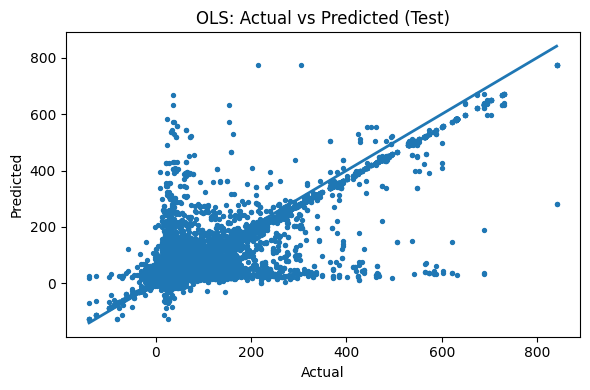

In [ ]:
# ---------- 7) Quick Diagnostic Plots ----------
plt.figure(figsize=(6,4))
plt.scatter(y_test, pred_ols, s=8)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], lw=2)
plt.title("OLS: Actual vs Predicted (Test)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.tight_layout()
plt.show()

We generate diagnostic visualizations:

Actual vs. Predicted Scatter Plot: checks model accuracy and systematic bias.

Residual Histogram: shows error distribution and helps confirm if residuals are approximately centered around zero.

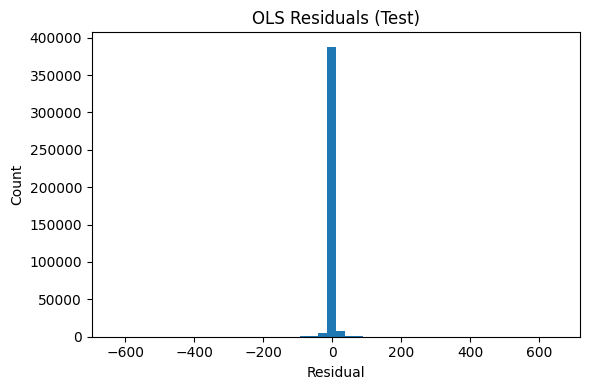

In [ ]:
plt.figure(figsize=(6,4))
resid = y_test - pred_ols
plt.hist(resid, bins=50)
plt.title("OLS Residuals (Test)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

We summarize takeaways and documentation points:

The features used (calendar + day-ahead + lag1). The calendar features include day_of_week, hour_of_day, month are used to recognize the patterns and the lag1 to capture short-term temporal dependencies. The day-ahead data is used if available.

Justification for time-based split (to prevent leakage): The time based splits is used to ensure the model only sees past data when trained. Using the first 80% for training and the most recent 20% for testing, ensures that our model simulates real-world forecasting without using future information.

Interpretation of MAE/RMSE/R² metrics.
MAE- Mean Absolute Error, measures average magnitude of errors between observations. The train MAE is 4.112 and the test MAE is 3.694. The predictions differ slightly (approx 0.4). The small difference indicates that the model generalizes well.
RMSE- Root Mean Squared Error, expresses the differences between values predicted by a model and the actual values. The train RMSE is 19.904 and the test RMSE is 13.345. This indicates the model has significant errors on training set as it is a larger number. In the testing set, the lower RMSE indicates a better model fit.
R²-Coefficient of determination, it is the percentage of variance in a target that is explained by the model. The train R² is 0.842 and the test R² is 0.820. Snice both percentages are pretty high indicating the model's predictions are closer to the actual data points. The test R² is 82% on unseen data indicates the model is a good fit.

This regression serves as a baseline, to be enhanced later with deep learning models (Milestone 3) that handle more complex temporal dependencies and nonstationarity.